<a href="https://colab.research.google.com/github/janbanot/msc-cs-code/blob/main/sem3/DL/DL_2025_Lab4C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo

# Import potrzebnych modułów i funkcji

# Importy z biblioteki standardowej
from collections import defaultdict
from random import random

# Importy z bibliotek zewnętrznych
import numpy as np
import torch
import torch.functional as F
from torch import nn, tensor
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import Subset
import random
from torchvision import datasets, transforms, models
from PIL import Image

# Importy do wizualizacji
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm

# Dodatkowe importy
from torchinfo import summary

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    ConfusionMatrixDisplay, classification_report, roc_auc_score
)

In [ ]:
%%html
<!-- Potrzebne dla poprawnego wyświetlania tqdm w VSCode https://stackoverflow.com/a/77566731 -->
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

# Uczenie transferowe na przykładzie sieci konwolucyjnych

In [ ]:
# Obliczenia wykonamy na GPU, jeżeli jest dostępne, a na CPU w przeciwny razie
def get_device():
  return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

get_device()

device(type='cuda')

In [ ]:
def train_model(model, train_loader, test_loader,
                optimizer,
                n_epochs=20, eval_every=1,
                device=None,
                history=None):
    device = device or get_device()

    history = history or defaultdict(list)
    # Przenieś model na określone urządzenie
    model.to(device)

    # Definiowanie funkcji straty
    compute_loss = nn.CrossEntropyLoss()

    test_loss = history['test_loss'][-1] if history['test_loss'] else 0
    test_accuracy = history['test_accuracy'][-1] if history['test_accuracy'] else 0

    # Pętla treningowa
    for epoch in range(n_epochs):
        model.train()  # Ustaw model w tryb treningowy

        total_loss = 0
        total_samples = 0
        total_correct = 0

        # Iteracja po danych treningowych
        for x_batch, y_batch in tqdm(train_loader):
            # Przenieś dane na określone urządzenie
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()  # Wyzerowanie gradientów przed kolejną iteracją
            out = model(x_batch)  # Faza w przód

            loss = compute_loss(out, y_batch)

            loss.backward()   # Faza wsteczna do obliczenia gradientów
            optimizer.step()  # Aktualizacja parametrów modelu

            total_samples += x_batch.shape[0]
            total_loss += loss.item() * x_batch.shape[0]

            predicted = torch.argmax(out, -1)
            total_correct += (predicted == y_batch).sum().item()

        train_loss = total_loss / total_samples
        train_accuracy = total_correct / total_samples

        if (epoch + 1) % eval_every == 0:  # Ewaluacja na zbiorze testowym
            model.eval()   # Ustaw model w tryb ewaluacji
            total_loss = 0
            total_samples = 0
            total_correct = 0
            with torch.no_grad():  # Wyłączenie obliczania gradientów
                for x_batch, y_batch in tqdm(test_loader):
                    # Przenieś dane na określone urządzenie
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                    out = model(x_batch)  # Faza w przód

                    loss = compute_loss(out, y_batch)

                    total_samples += x_batch.shape[0]
                    total_loss += loss.item() * x_batch.shape[0]

                    predicted = torch.argmax(out, -1)
                    total_correct += (predicted == y_batch).sum().item()

            test_loss = total_loss / total_samples
            test_accuracy = total_correct / total_samples

            print(f'Epoch: {epoch}\tTrain loss: {train_loss:.3f}'\
                  f'\tTrain acc: {train_accuracy:.3f}'\
                  f'\tTest loss: {test_loss:.3f}'\
                  f'\tTest acc: {test_accuracy:.3f}')
        else:
            print(f'Epoch: {epoch}\tTrain loss: {train_loss:.3f}'\
                  f'\tTrain acc: {train_accuracy:.3f}')

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)

        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_accuracy)

    return history


def plot_train_history(history):
    # Wizualizacja historii treningu:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))  # 1 wiersz, 2 kolumny

    n_epochs = len(history['train_loss'])
    eval_every = n_epochs // len(history['test_loss'])
    xs = range(0, n_epochs, eval_every)
    # Strata
    ax1.set_ylabel('Strata')
    ax1.set_xlabel('Epoka')
    ax1.plot(history['train_loss'], color='green')
    ax1.plot(history['test_loss'], color='orange')
    ax1.legend(['train', 'test'])

    ax2.set_ylabel('Dokładność')
    ax2.set_xlabel('Epoka')
    ax2.plot(history['train_accuracy'], color='green')
    ax2.plot(history['test_accuracy'], color='orange')
    ax2.legend(['train', 'test'])

    plt.show()

## Wybór modelu

`TorchVision` oferuje bogatą [listę modeli](https://pytorch.org/vision/main/models.html).

Wybieramy [ResNet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), który jest względnie prosty, ale powinien być szybki.

In [ ]:
batch_size = 32
torch.manual_seed(42)  # Reset ziarna generatora, dla powtarzalności wyników

# Ładujemy model ResNet-18 wraz z wytrenowanymi na ImageNet wagami
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# "Zamrażamy" parametry sieci
for param in model.parameters():
    param.requires_grad = False

# Podmieniamy warstwę wyjściową
num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 10)  # 10 bo liczba klas dla CIFAR-10

model.fc = nn.Sequential(
    nn.Linear(num_features, 50),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(50, 10)
)

learning_rate = 0.001

In [ ]:
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  (36,864)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  (36,864)
│    │    └─BatchNorm2d: 3-5             (128)
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  (36,864)
│    │    └─BatchNorm2d: 3-7             (128)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (36,864)
│    │    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11   

Każdy model wymaga danych o określonym wymiarze.
Gotowe *transformacje* można znaleźć w zestawie z wagami.
Na ich podstawie będzie można dopasować obrazy 32x32 ze zbioru CIFAR-10
do obrazów 224x224 wymaganych przez ResNet-18

In [ ]:
transform = models.ResNet18_Weights.IMAGENET1K_V1.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Alternatywnie, możemy samodzielnie zdefniować transformacje:

In [ ]:
from torchvision.transforms import InterpolationMode

transform = transforms.Compose([
    # Resize the shorter side of the image to 256 pixels using bilinear interpolation
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    # Center crop the image to 224x224 pixels
    transforms.CenterCrop(224),
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # transforms.RandomHorizontalFlip(),  # <- dodatkowo
    # Normalize the tensor with the specified mean and standard deviation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True,
                                 transform=transform)

# W celu skrócenia czasu obliczeń ograniczymy się do 5000 losowo wybranych
# obrazów (z 50 000)
train_subset = Subset(train_dataset,
                      indices=random.sample(range(len(train_dataset)), 5_000))

# Cały zbiór testowy, tj. 10 000 obrazów
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True,
                                transform=transform)
test_subset = Subset(test_dataset,
                     indices=random.sample(range(len(test_dataset)), 5_000))

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0	Train loss: 1.547	Train acc: 0.489


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1	Train loss: 1.041	Train acc: 0.641


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2	Train loss: 0.889	Train acc: 0.704


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3	Train loss: 0.831	Train acc: 0.718


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4	Train loss: 0.816	Train acc: 0.709	Test loss: 0.777	Test acc: 0.732


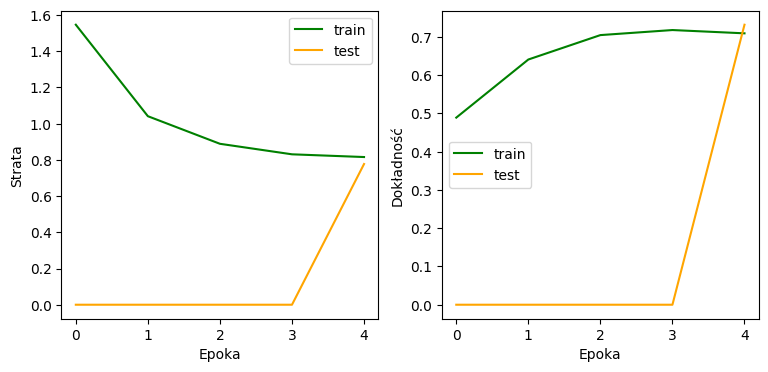

In [ ]:
history = train_model(model, train_loader, test_loader,
            optimizer=optim.AdamW(model.parameters(), lr=learning_rate),
            n_epochs=5,
            eval_every=5)

plot_train_history(history)

## Faza II -- dostrajanie

Po zakończeniu podstawowego treningu (nowej) warstwy wyjściowej, możemy
odmrozić wszystkie warstwy w celu ,,delikatnego'' dostrojenia.

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 0	Train loss: 0.582	Train acc: 0.797	Test loss: 0.444	Test acc: 0.844


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1	Train loss: 0.182	Train acc: 0.941	Test loss: 0.400	Test acc: 0.866


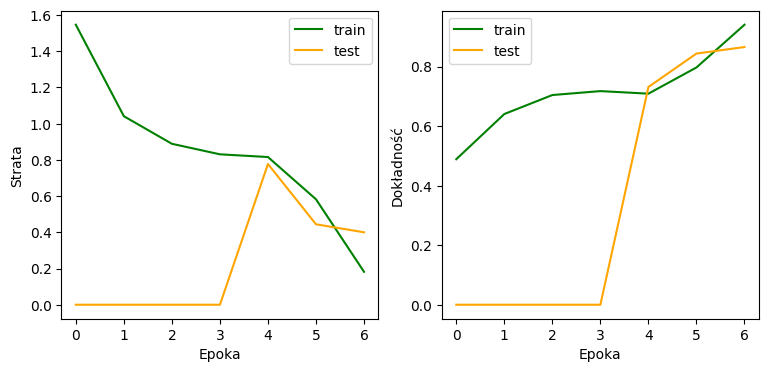

In [ ]:
# "Odmrażamy" parametry sieci
for param in model.parameters():
    param.requires_grad = True  # Parametr będzie ulegał korekcji w trakcie treningu

history = train_model(model, train_loader, test_loader,
            optimizer=optim.AdamW(model.parameters(), lr=learning_rate / 10),
            n_epochs=2,
            history=history,
            eval_every=1)

plot_train_history(history)

## A teraz, czy to zadziała dla zdjęcia spoza zbioru testowego?

Możemy sprawdzić, czy model poprawnie rozpozna zdjęcie, np. pobrane z serwisu [unsplash](https://images.unsplash.com/photo-1511194872177-813cf1cd32bb?q=80&w=2670&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D).

In [ ]:
!wget -O horse.jpeg  "https://images.unsplash.com/photo-1511194872177-813cf1cd32bb?q=80&w=2670&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

--2024-11-10 17:30:56--  https://images.unsplash.com/photo-1511194872177-813cf1cd32bb?q=80&w=2670&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 461160 (450K) [image/jpeg]
Saving to: ‘horse.jpeg’

horse.jpeg          100%[===================>] 450.35K  --.-KB/s    in 0.03s   

2024-11-10 17:30:57 (12.9 MB/s) - ‘horse.jpeg’ saved [461160/461160]



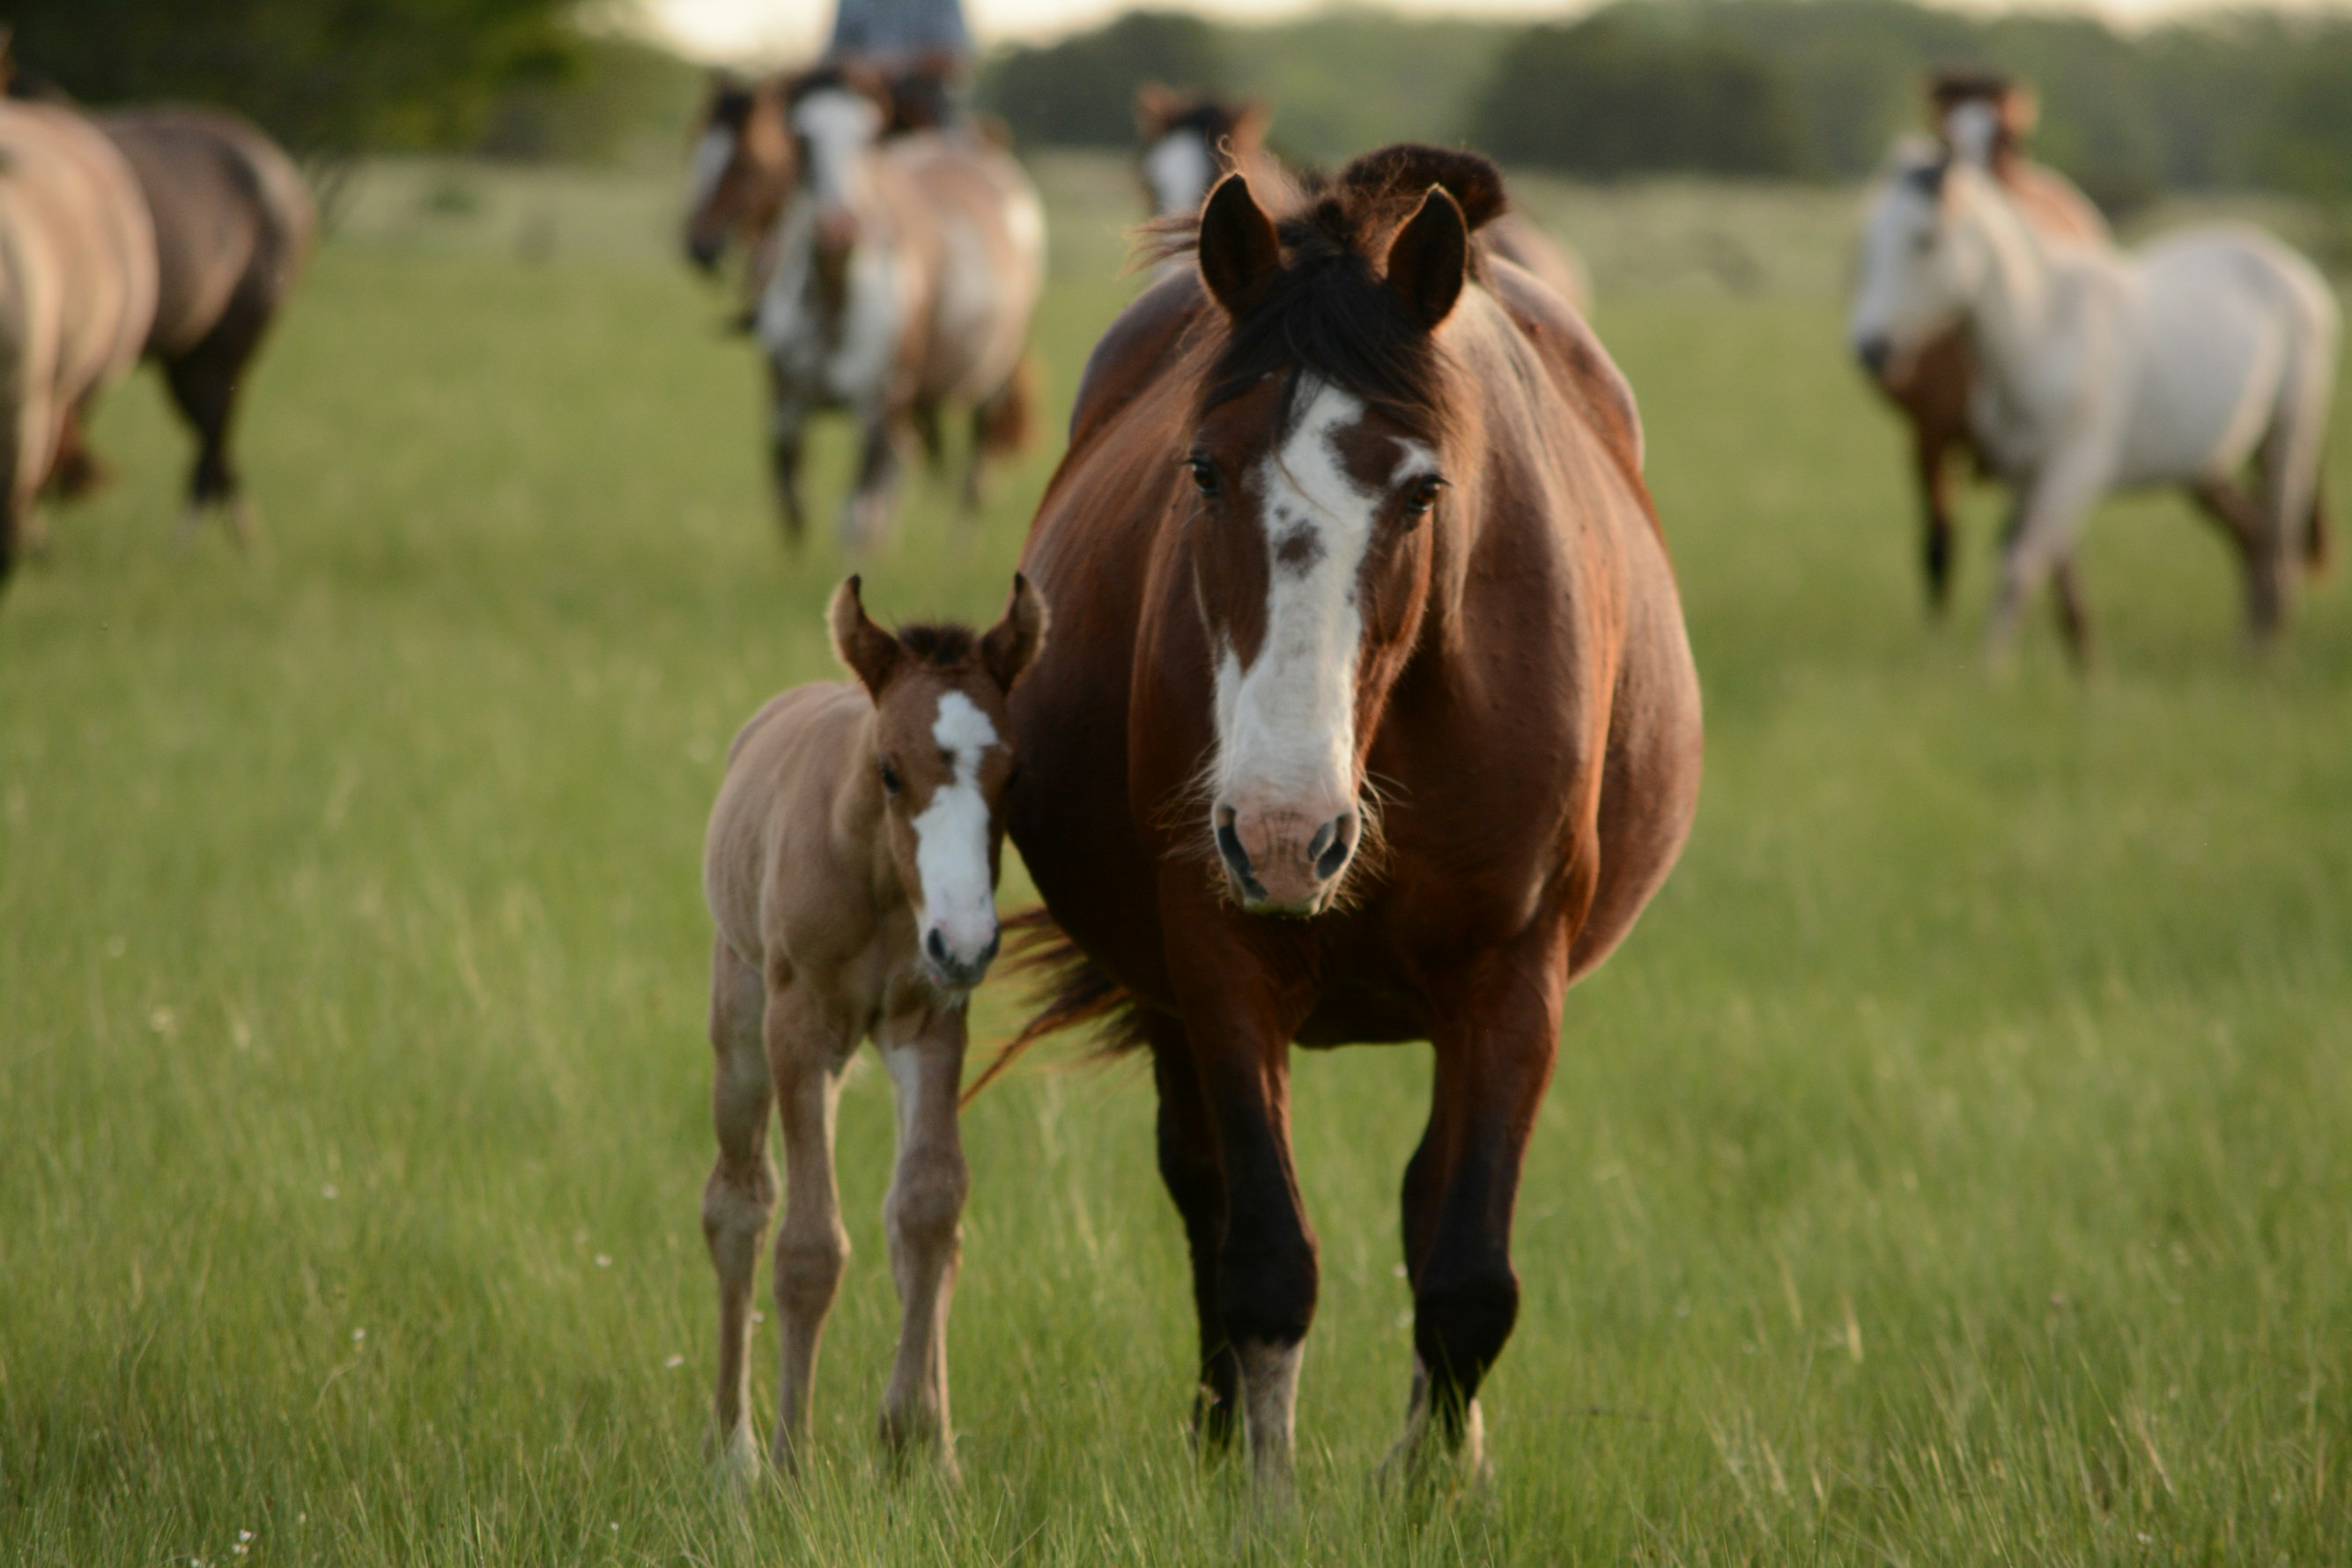

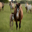

In [ ]:
image_path = 'horse.jpeg'
raw_image = big_image = Image.open(image_path)
display(raw_image);

# Uwaga, zbiór CIFAR-10 ma zdjęcia w rozdzielczości 32x32 -- dopasowanie do tego wymiaru
# może poprawić(!) dokładność klasyfikacji, pomimo odrzucenia większości informacji
raw_image = raw_image.resize((32, 32))
display(raw_image);

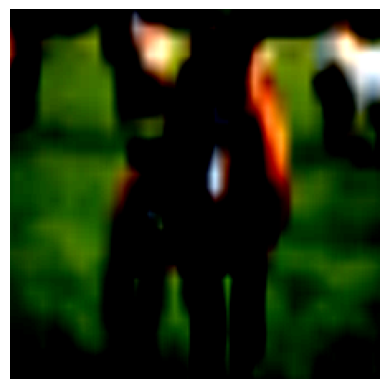

In [ ]:
# Obraz należy dopasować do formy wymaganej przez sieć:
transform = models.ResNet18_Weights.IMAGENET1K_V1.transforms()
image = transform(raw_image)

# Jak wygląda obraz na wejściu sieci?
image_to_show = image.permute(1, 2, 0).clamp(0, 1)

plt.imshow(image_to_show)
plt.axis('off')
plt.show()

In [ ]:
# Dodajemy wymiar, bo sieć potrzbuje [Batch, Channel, Width, Height],
# a nie tylko [Channel, Width, Height]
image_to_input = image.unsqueeze(0).to(get_device())

model.eval()  # Tryb ewaluacji
with torch.no_grad():
    outputs = model(image_to_input)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predicted_class = probabilities.argmax(dim=1).item()

print(f"Predicted class: {test_dataset.classes[predicted_class]} with prob. {probabilities[0][predicted_class].item():.2f}")

Predicted class: horse with prob. 0.99


# Przygotowanie zdjęć do treningu

Korzystanie z **gotowych** zestawów zdjęć z `torchvision.datasets` jest wygodne,
ale niewiele trudniejesze jest przetwarzanie własnych zestawów zdjęć.

Ułatwia to, np. klasa `torchvision.datasets.ImageFolder`

Możemy spróbować, np. ze zbiorem zdjęć sinic z dostępnego na github [repozytorium](https://github.com/iman2693/CTCB)

In [ ]:
!wget https://github.com/iman2693/CTCB/archive/refs/heads/main.zip -O CTCB-main.zip
!unzip CTCB-main.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
 extracting: CTCB-main/dataset-processed/Test/Microcystis/img167_2_a7164.png  
 extracting: CTCB-main/dataset-processed/Test/Microcystis/img167_4_6aaef.png  
 extracting: CTCB-main/dataset-processed/Test/Microcystis/img168_3_99f24.png  
 extracting: CTCB-main/dataset-processed/Test/Microcystis/img169_4_2a067.png  
 extracting: CTCB-main/dataset-processed/Test/Microcystis/img169_5_919a8.png  
 extracting: CTCB-main/dataset-processed/Test/Microcystis/img169_6_df468.png  
  inflating: CTCB-main/dataset-processed/Test/Microcystis/img16_2_ba4a2.png  
 extracting: CTCB-main/dataset-processed/Test/Microcystis/img171_6_b42ff.png  
 extracting: CTCB-main/dataset-processed/Test/Microcystis/img172_1_dd3cd.png  
 extracting: CTCB-main/dataset-processed/Test/Microcystis/img175_2_5b943.png  
 extracting: CTCB-main/dataset-processed/Test/Microcystis/img175_4_f5972.png  
 extracting: CTCB-main/dataset-processed/Test/Microcystis/img177_1_

In [ ]:
import pathlib
from torchvision.datasets import ImageFolder


transform = transforms.Compose([
    transforms.Resize(224, antialias=True),  # Resize to the input size expected by ResNet
    transforms.CenterCrop(222),  # Crop the center to create a square
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization as per ImageNet stats
])

train_imgs = ImageFolder(root=pathlib.Path('CTCB-main/dataset/Train'), transform=transform)
test_imgs = ImageFolder(root=pathlib.Path('CTCB-main/dataset/Test'), transform=transform)

f'{train_imgs.classes=} {len(train_imgs)=}'

"train_imgs.classes=['Anabaena', 'Aphanizomenon', 'Cylindrospermopsis', 'Dolichospermum', 'Microcystis', 'Nostoc', 'Oscillatoria', 'Phormidium', 'Planktothrix', 'Raphidiopsis'] len(train_imgs)=2073"

In [ ]:
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_imgs)

In [ ]:
torch.manual_seed(42)  # Reset ziarna generatora, dla powtarzalności wyników

# Ładujemy model ResNet-18 wraz z wytrenowanymi na ImageNet wagami
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# "Zamrażamy" parametry sieci
for param in model.parameters():
    param.requires_grad = False

# Podmieniamy warstwę wyjściową
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_imgs.classes))

learning_rate = 0.001

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch: 0	Train loss: 1.196	Train acc: 0.612


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch: 1	Train loss: 0.658	Train acc: 0.781


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch: 2	Train loss: 0.538	Train acc: 0.822


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch: 3	Train loss: 0.476	Train acc: 0.839


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 4	Train loss: 0.426	Train acc: 0.848	Test loss: 0.365	Test acc: 0.880


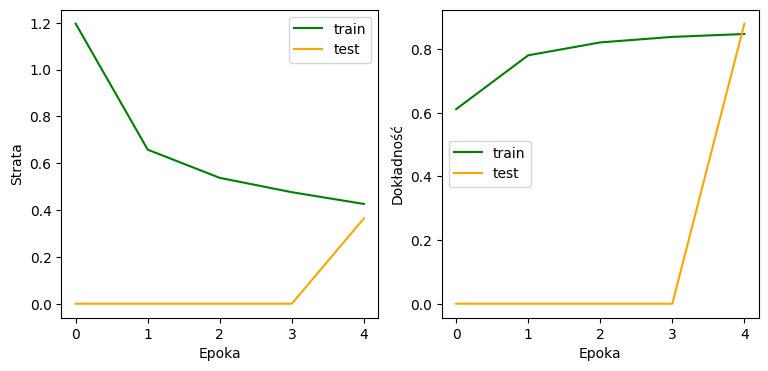

In [ ]:
history = train_model(model, train_loader, test_loader,
            optimizer=optim.AdamW(model.parameters(), lr=learning_rate),
            n_epochs=5,
            eval_every=5)

plot_train_history(history)

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 0	Train loss: 0.366	Train acc: 0.869	Test loss: 0.220	Test acc: 0.925


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 1	Train loss: 0.128	Train acc: 0.959	Test loss: 0.213	Test acc: 0.923


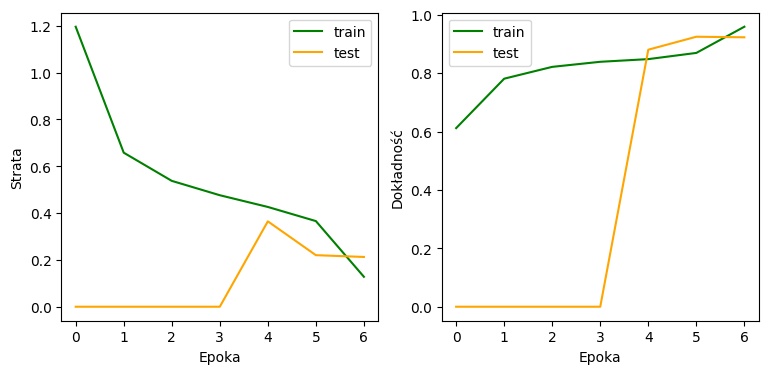

In [ ]:
# "Odmrażamy" parametry sieci
for param in model.parameters():
    param.requires_grad = True  # Parametr będzie ulegał korekcji w trakcie treningu

history = train_model(model, train_loader, test_loader,
            optimizer=optim.AdamW(model.parameters(), lr=learning_rate / 10),
            n_epochs=2,
            history=history,
            eval_every=1)

plot_train_history(history)

In [ ]:
def show_classification_metrics(model, data_loader, device=None, class_names=None):
    if device is None:
        device = get_device()
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for x_batch, y_batch in data_loader:
            # Move data to the specified device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Prediction
            out = model(x_batch)
            preds = torch.argmax(out, -1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Determine the unique labels
    if class_names is not None:
        labels = np.arange(len(class_names))
    else:
        labels = np.unique(np.concatenate((all_labels, all_preds)))

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    num_errors = len(all_labels) - np.sum(all_preds == all_labels)

    # Display the confusion matrix
    if class_names is not None:
        if len(labels) != len(class_names):
            raise ValueError("Number of class names must match number of labels.")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    # Rotate the x-axis labels by 90 degrees
    plt.setp(disp.ax_.get_xticklabels(), rotation=90)
    plt.show()

    # Display additional information
    print(f'Number of errors: {num_errors}')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1-score: {f1:.3f}')

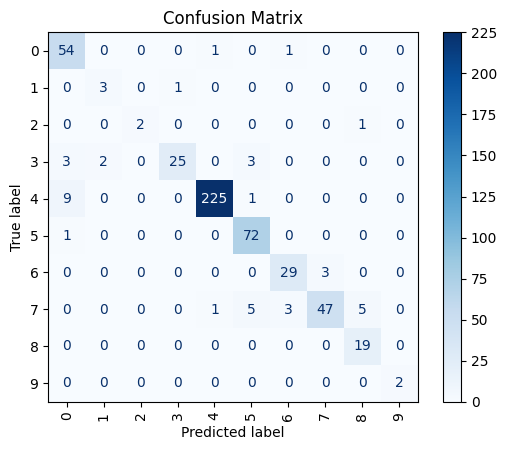

Number of errors: 40
Accuracy: 0.923
Precision: 0.930
Recall: 0.923
F1-score: 0.923


In [ ]:
show_classification_metrics(model, test_loader)

# Zadanie 3 (z sieci konwolucyjnych)

Proszę zastosować *uczenie transferowe* do rozwiązania problemu klasyfikacji zdjęć przedstawiających
cyfry w angielskim języku migowym https://github.com/ardamavi/Sign-Language-Digits-Dataset

* Proszę wybrać i porównać ze sobą *dwa* modele z [listy PyTorch](https://pytorch.org/vision/main/models.html) nie większe niż 20 mln parametrów
* Czy użycie dodatkowych transformacji na wejściu sieci, np. odbicie w poziomie, wymazywanie, jest w stanie podnieść dokładność modelu?
* Czy dodanie 2 warstw na wyjściu zamiast 1 poprawi jakość klasyfikacji?